<a href="https://colab.research.google.com/github/alen217/non-stick-cooking-pan-detection/blob/master/PanProjectMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
from google.colab import drive
import os

# Mount your Google Drive (do this first if not already mounted)
# drive.mount('/content/drive') # Already done in the first cell

# Define the source and destination paths
source_folder = '/content/drive/MyDrive/dataset'  # This is your folder in Drive
destination_folder = '/content/dataset'           # This is where you want it in Colab

# Check if the destination folder already exists. If so, remove it to avoid errors.
if os.path.exists(destination_folder):
    print(f"Removing existing folder: {destination_folder}")
    shutil.rmtree(destination_folder)

# Copy the folder from your Drive to Colab
try:
    shutil.copytree(source_folder, destination_folder)
    print(f"Folder successfully copied to {destination_folder}")
except FileNotFoundError:
    print(f"Error: The source folder was not found at {source_folder}")
    print("Please double-check the folder name and its location in your Google Drive.")
except Exception as e:
    print(f"An unexpected error occurred during copying: {e}")

print("Contents of destination folder:", os.listdir(destination_folder) if os.path.exists(destination_folder) else "Destination folder does not exist.")

Folder successfully copied to /content/dataset
Contents of destination folder: ['Severe_Wear', 'Moderate_Wear', 'New_No_Wear', 'Minor_Wear']


In [ ]:
# Step 1: Import all necessary libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from google.colab import files # For downloading the final model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

# --------------------------------------------------------------------------
# Step 2: Define the correct path to your dataset
# This is the ONLY line you might ever need to change.
DATASET_PATH = '/content/drive/MyDrive/dataset'
# --------------------------------------------------------------------------

# --- Configuration ---
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
EPOCHS = 25

# --- Image Pre-processing Function ---
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_img = clahe.apply(gray_img)
    denoised_img = cv2.medianBlur(contrast_img, 5)
    kernel = np.ones((5, 5), np.uint8)
    black_hat = cv2.morphologyEx(denoised_img, cv2.MORPH_BLACKHAT, kernel)
    processed_img = np.expand_dims(black_hat, axis=-1)
    return processed_img

# --- Data Loading Function ---
def load_dataset(dataset_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))
    label_map = {name: i for i, name in enumerate(class_names)}
    print(f"Found classes: {class_names}")
    print(f"Mapping labels: {label_map}")

    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path): continue
        print(f"\nProcessing class: {class_name}")
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                try:
                    processed_image = preprocess_image(image_path)
                    images.append(processed_image)
                    labels.append(label_map[class_name])
                except Exception as e:
                    print(f"  - Could not process {image_name}. Error: {e}")
    return np.array(images), np.array(labels), len(class_names)

# --- Main Execution Block ---

# Load and process all data
X, y, num_classes = load_dataset(DATASET_PATH)
print(f"\nDataset loaded. Total images: {len(X)}, Number of classes: {num_classes}")

# Normalize pixel values
X = X / 255.0

# One-Hot Encode the labels
y_categorical = to_categorical(y, num_classes=num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

# Build the CNN Model
model = Sequential([
    Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Train the Model
print("\n--- Starting Model Training ---")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)
print("\n--- Training Complete ---")

# Save and Download the Model
model_filename = 'wear_multiclass_model.h5'
model.save(model_filename)
print(f"\n✅ Model saved as {model_filename}")
files.download(model_filename)
print(f"Downloading {model_filename} to your local machine.")

Found classes: ['Minor_Wear', 'Moderate_Wear', 'New_No_Wear', 'Severe_Wear']
Mapping labels: {'Minor_Wear': 0, 'Moderate_Wear': 1, 'New_No_Wear': 2, 'Severe_Wear': 3}

Processing class: Minor_Wear

Processing class: Moderate_Wear

Processing class: New_No_Wear

Processing class: Severe_Wear

Dataset loaded. Total images: 121, Number of classes: 4
Training set size: 96
Validation set size: 25


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,916 (56.61 MB)

 Trainable params: 14,838,916 (56.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.2591 - loss: 1.3816 - val_accuracy: 0.3200 - val_loss: 1.2952
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.3932 - loss: 1.2821 - val_accuracy: 0.3600 - val_loss: 1.2269
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.5365 - loss: 1.1977 - val_accuracy: 0.5200 - val_loss: 1.0324
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.7630 - loss: 0.8523 - val_accuracy: 0.5600 - val_loss: 0.9584
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.7161 - loss: 0.7275 - val_accuracy: 0.7200 - val_loss: 1.1055
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.8646 - loss: 0.4022 - val_accuracy: 0.6000 - val_loss: 1.4005
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.8633 - loss: 0.4255 - val_accuracy: 0.6000 - val_loss: 1.5761
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.8594 - loss: 0.3771 - val_accuracy: 0


--- Training Complete ---

✅ Model saved as wear_multiclass_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Example of saving the model
from tensorflow.keras.models import load_model
import os

# Define the path where the model was saved during training
model_path_in_colab = '/content/drive/MyDrive/Colab Notebooks/wear_multiclass_model.h5'

# Define the desired path in Google Drive to save the model
model_path_in_drive = '/content/drive/MyDrive/Colab Notebooks/wear_multiclass_model.h5'

# Load the model from the path in Colab
try:
    model = load_model(model_path_in_colab)
    print(f"Model loaded successfully from {model_path_in_colab}")

    # Ensure the target directory in Google Drive exists before saving
    drive_dir = os.path.dirname(model_path_in_drive)
    if not os.path.exists(drive_dir):
        os.makedirs(drive_dir)
        print(f"Created directory: {drive_dir}")

    # Save the model to Google Drive
    model.save(model_path_in_drive)
    print(f"Model saved successfully to {model_path_in_drive}")

except Exception as e:
    print(f"An error occurred: {e}")
    model = None # Set model to None if any step fails

Model loaded successfully from /content/drive/MyDrive/Colab Notebooks/wear_multiclass_model.h5
Model saved successfully to /content/drive/MyDrive/Colab Notebooks/wear_multiclass_model.h5


Loading model from /content/drive/My Drive/Colab Notebooks/wear_multiclass_model.h5...


Model loaded successfully.


Saving image1.jpg to image1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step

          PREDICTION RESULT
Predicted Class: Minor_Wear
Confidence: 99.98%



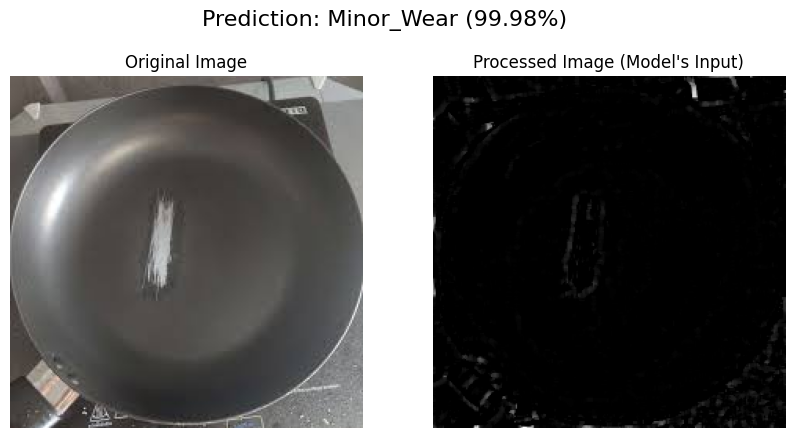

Cleaned up uploaded file: image1.jpg


In [ ]:
#upload
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
from google.colab import files # Import files for Colab file upload

# --- Configuration ---
# Update the MODEL_PATH to the location in your Google Drive
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/wear_multiclass_model.h5'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# IMPORTANT: The order of these labels MUST match the alphabetical order
# of the folders in your training dataset.
CLASS_LABELS = ['Minor_Wear', 'Moderate_Wear', 'New_No_Wear', 'Severe_Wear']

# --- 1. Define the exact same pre-processing function used for training ---
def preprocess_for_prediction(image_path):
    """
    Loads an image, processes it exactly like the training data,
    and prepares it for prediction.
    """
    img = cv2.imread(image_path)
    if img is None:
        # If reading with cv2 fails, try with matplotlib (sometimes works for different image types)
        try:
            img = plt.imread(image_path)
            # Convert grayscale or alpha channel images to BGR if necessary for cv2 processing
            if img.ndim == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            elif img.shape[2] == 4:
                 img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
            else:
                 img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        except Exception as e:
             raise FileNotFoundError(f"Could not read image file at {image_path} using both cv2 and matplotlib. Error: {e}")


    # Store the original for display later (convert BGR to RGB for matplotlib)
    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to the standard size
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))

    # a) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # b) Enhance contrast with CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_img = clahe.apply(gray_img)

    # c) Reduce noise with Median Blur
    denoised_img = cv2.medianBlur(contrast_img, 5)

    # d) Isolate wear features with Black-Hat
    kernel = np.ones((5, 5), np.uint8)
    black_hat = cv2.morphologyEx(denoised_img, cv2.MORPH_BLACKHAT, kernel)

    # e) Normalize and reshape for the CNN input
    processed_img = black_hat / 255.0
    processed_img_for_model = np.expand_dims(processed_img, axis=-1) # Add channel dimension
    processed_img_for_model = np.expand_dims(processed_img_for_model, axis=0) # Add batch dimension

    return original_img, processed_img, processed_img_for_model

# --- 2. Main Prediction Function ---
def predict_from_uploaded_image():
    """
    Uses google.colab.files to upload an image, loads a model,
    processes the uploaded image, and prints the prediction.
    """
    # Check if the model file exists
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at '{MODEL_PATH}'")
        print("Please make sure the .h5 file is in the correct Google Drive path.")
        return

    # Load the trained model
    print(f"Loading model from {MODEL_PATH}...")
    model = load_model(MODEL_PATH)
    print("Model loaded successfully.")

    # Use google.colab.files to upload an image
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return

    # Get the filename of the uploaded file
    # Note: files.upload() returns a dictionary where keys are filenames
    uploaded_filename = list(uploaded.keys())[0]
    image_path = uploaded_filename # The file is uploaded to the current directory

    try:
        # Process the selected image
        original, processed, model_input = preprocess_for_prediction(image_path)

        # Make a prediction
        prediction = model.predict(model_input)

        # Get the class with the highest probability
        predicted_class_index = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        predicted_class_label = CLASS_LABELS[predicted_class_index]

        # --- 3. Display the results ---
        print("\n" + "="*30)
        print("          PREDICTION RESULT")
        print("="*30)
        print(f"Predicted Class: {predicted_class_label}")
        print(f"Confidence: {confidence:.2f}%")
        print("="*30 + "\n")

        # Show the original image and the processed image the model "saw"
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Processed Image (Model's Input)")
        plt.imshow(processed, cmap='gray') # Use cmap='gray' for grayscale image
        plt.axis('off')

        plt.suptitle(f"Prediction: {predicted_class_label} ({confidence:.2f}%)", fontsize=16)
        plt.show()

    except FileNotFoundError as e:
         print(f"Error processing file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        # Clean up the uploaded file after processing
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Cleaned up uploaded file: {image_path}")


# --- Run the prediction script ---
if __name__ == '__main__':
    predict_from_uploaded_image()

In [ ]:
# Display the model summary again
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,918 (56.61 MB)

 Trainable params: 14,838,916 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

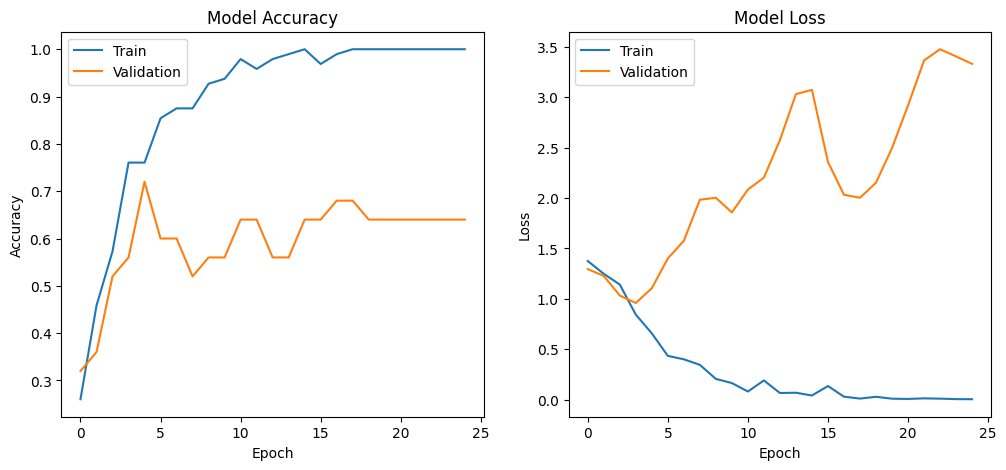


Training and validation plots generated.


In [ ]:
# Add more graphs: Plot training and validation history

import matplotlib.pyplot as plt

# Ensure the 'history' object is available from the training cell
if 'history' not in globals():
    print("Error: 'history' object not found. Please run the model training cell first.")
else:
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    print("\nTraining and validation plots generated.")

Displaying sample images from each category...


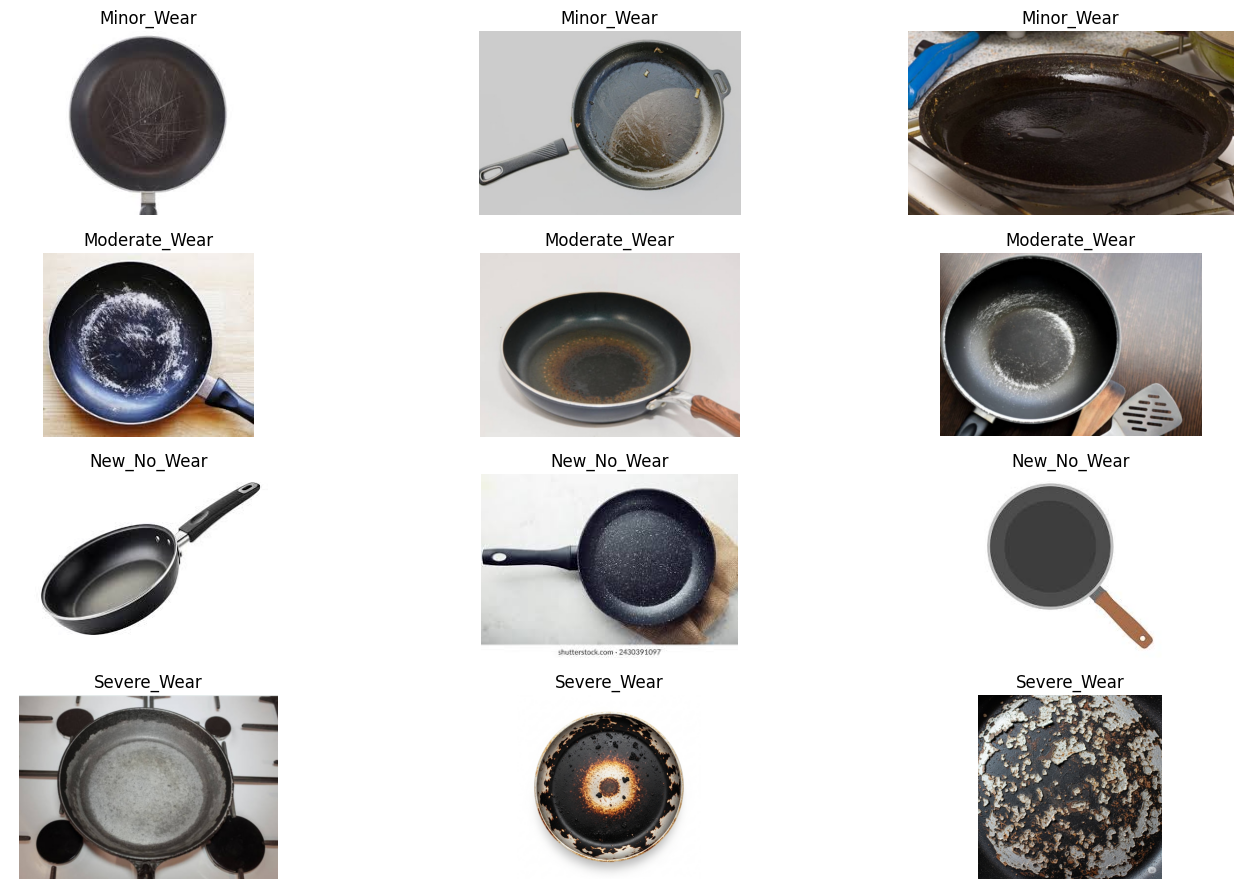


Sample image visualization complete.


In [ ]:
# Add graphs to visualize sample data

import matplotlib.pyplot as plt
import os
import random

# Ensure DATASET_PATH and CLASS_LABELS are defined from previous cells
if 'DATASET_PATH' not in globals() or 'CLASS_LABELS' not in globals():
    print("Error: DATASET_PATH or CLASS_LABELS not found. Please run the data loading cell first.")
else:
    print("Displaying sample images from each category...")

    # Number of samples to display per class
    num_samples_per_class = 3

    plt.figure(figsize=(15, num_samples_per_class * 3))

    for i, class_name in enumerate(CLASS_LABELS):
        class_path = os.path.join(DATASET_PATH, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            # Select random samples, or take all if less than num_samples_per_class
            sample_images = random.sample(image_files, min(len(image_files), num_samples_per_class))

            for j, image_name in enumerate(sample_images):
                image_path = os.path.join(class_path, image_name)
                try:
                    img = plt.imread(image_path)
                    plt.subplot(len(CLASS_LABELS), num_samples_per_class, i * num_samples_per_class + j + 1)
                    plt.imshow(img)
                    plt.title(class_name)
                    plt.axis('off')
                except Exception as e:
                    print(f"Could not load or display image {image_name}: {e}")
        else:
            print(f"Warning: Class directory not found for {class_name} at {class_path}")

    plt.tight_layout()
    plt.show()

    print("\nSample image visualization complete.")

Analyzing and visualizing data distribution per class...


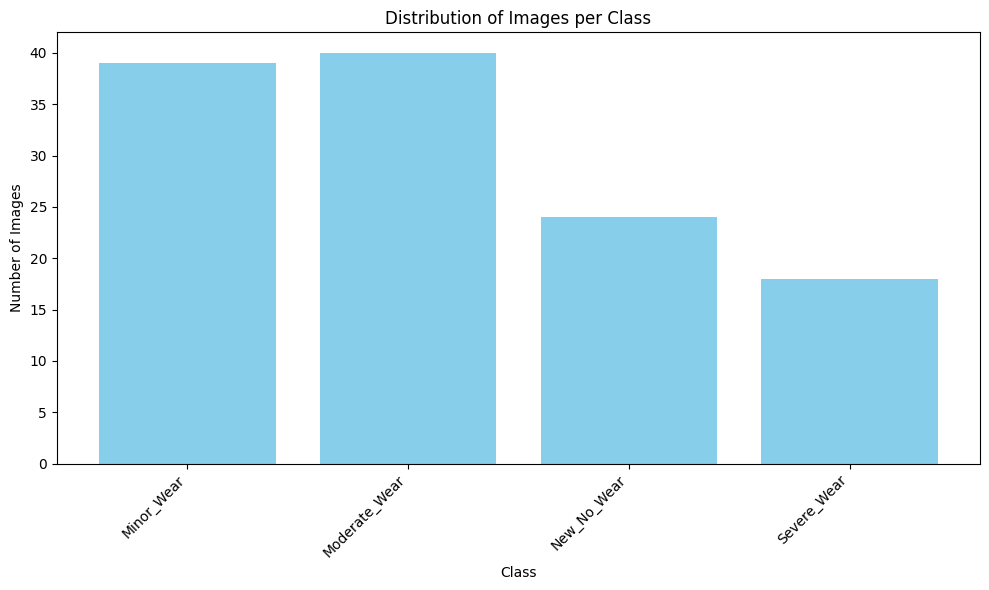


Data distribution visualization complete.


In [ ]:
# Add graph to visualize data distribution per class

import os
import matplotlib.pyplot as plt

# Ensure DATASET_PATH and CLASS_LABELS are defined from previous cells
if 'DATASET_PATH' not in globals() or 'CLASS_LABELS' not in globals():
    print("Error: DATASET_PATH or CLASS_LABELS not found. Please run the data loading cell first.")
else:
    print("Analyzing and visualizing data distribution per class...")

    class_counts = {}
    for class_name in CLASS_LABELS:
        class_path = os.path.join(DATASET_PATH, class_name)
        if os.path.isdir(class_path):
            # Count files in the directory (excluding subdirectories)
            count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = count
        else:
            class_counts[class_name] = 0
            print(f"Warning: Class directory not found for {class_name} at {class_path}. Count set to 0.")

    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images per Class')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

    print("\nData distribution visualization complete.")

# Task
Generate Python code to evaluate a trained classification model using accuracy, precision, recall, F1 score, confusion matrix, ROC AUC, and a classification report, and provide the code in a new cell.

## Make predictions

### Subtask:
Use the trained model to make predictions on the validation dataset (`X_val`).


**Reasoning**:
Use the trained model to predict on the validation data and convert the one-hot encoded true labels back to original class indices.



In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

# Convert predictions from probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to class indices
y_true_classes = np.argmax(y_val, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


## Calculate metrics

### Subtask:
Calculate accuracy, precision, recall, and F1 score using the true labels (`y_true_classes`) and the predicted labels (`y_pred_classes`).


**Reasoning**:
Calculate and print accuracy, precision, recall, and F1 score using the true and predicted class labels.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1 score (using 'weighted' average for multiclass)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

Accuracy: 0.6400
Precision (weighted): 0.6800
Recall (weighted): 0.6400
F1 Score (weighted): 0.6526


## Generate confusion matrix

### Subtask:
Compute and display the confusion matrix using the true labels (`y_true_classes`) and the predicted labels (`y_pred_classes`).


**Reasoning**:
Compute and visualize the confusion matrix using the true and predicted labels.



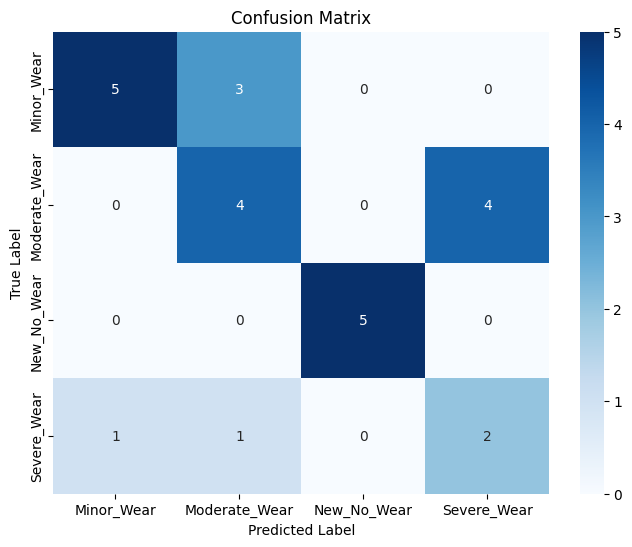

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Generate roc auc

### Subtask:
Calculate and plot the ROC curve and AUC score (for multi-class, this is often done using strategies like one-vs-rest).


**Reasoning**:
Calculate and plot the ROC curve and AUC score for each class using the one-vs-rest strategy.



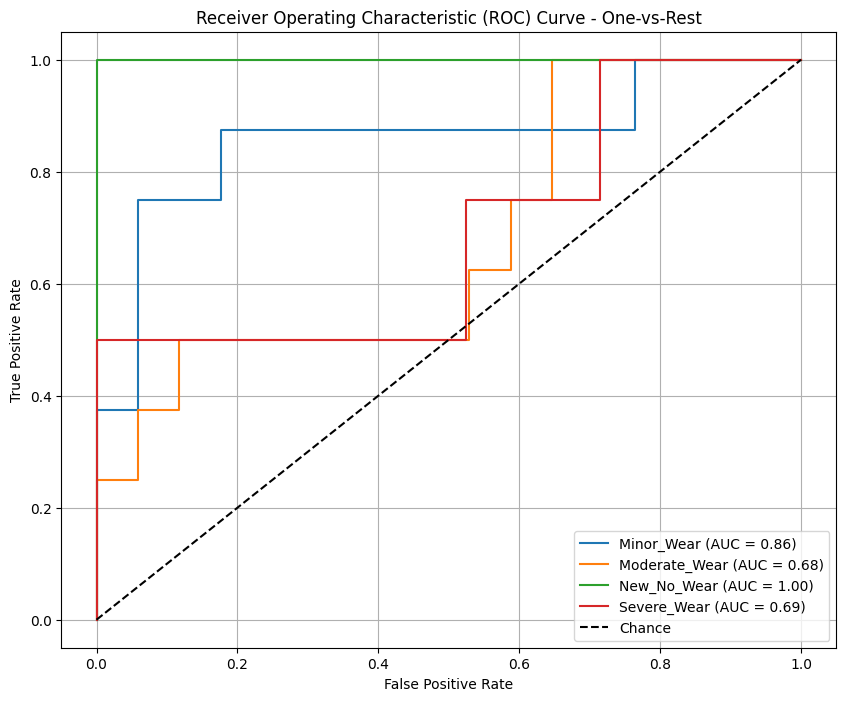


ROC curve and AUC score visualization complete.


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC curves for each class (One-vs-Rest)
plt.figure(figsize=(10, 8))

# Iterate through each class
for i in range(num_classes):
    # Calculate ROC curve and AUC for class i
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i]) # Use roc_curve directly
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, label=f'{CLASS_LABELS[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance') # Plot random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nROC curve and AUC score visualization complete.")

**Reasoning**:
The previous attempt to get the ROC curve data failed because `RocCurveDisplay.from_predictions` directly plots the curve and does not return `fpr` and `tpr` attributes in the way expected. I need to use `roc_curve` and `auc` functions directly to get the data points for plotting manually within the loop.



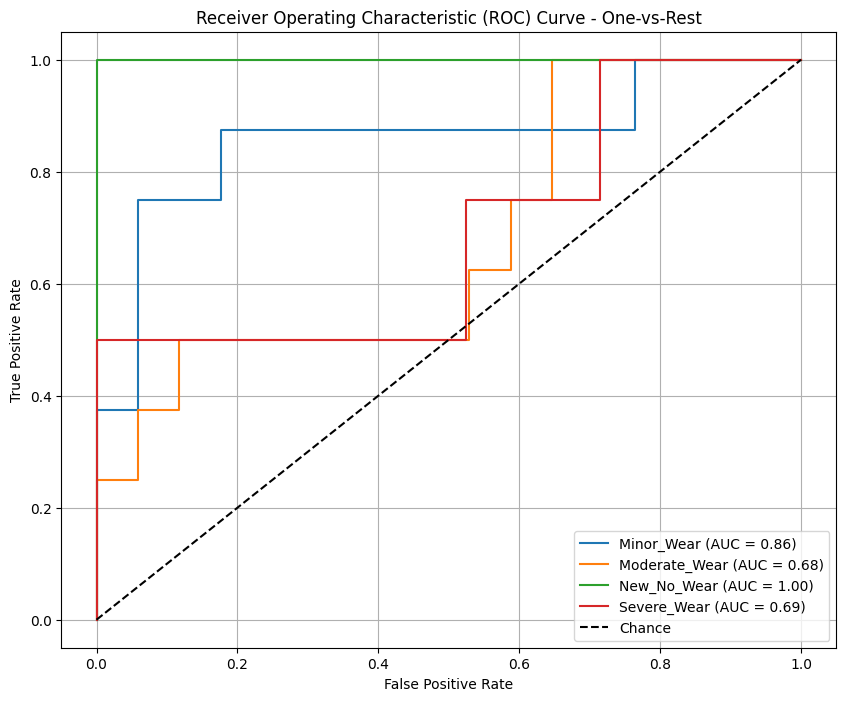


ROC curve and AUC score visualization complete.


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC curves for each class (One-vs-Rest)
plt.figure(figsize=(10, 8))

# Iterate through each class
for i in range(num_classes):
    # Calculate ROC curve and AUC for class i
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, label=f'{CLASS_LABELS[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance') # Plot random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nROC curve and AUC score visualization complete.")

## Generate classification report

### Subtask:
Display a text-based report with precision, recall, F1-score, and support for each class.


**Reasoning**:
Generate and print the classification report.



In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=CLASS_LABELS)

# Print the report
print("\nClassification Report:")
print(report)


Classification Report:
               precision    recall  f1-score   support

   Minor_Wear       0.83      0.62      0.71         8
Moderate_Wear       0.50      0.50      0.50         8
  New_No_Wear       1.00      1.00      1.00         5
  Severe_Wear       0.33      0.50      0.40         4

     accuracy                           0.64        25
    macro avg       0.67      0.66      0.65        25
 weighted avg       0.68      0.64      0.65        25



## Include threshold tuning (optional)

### Subtask:
Briefly discuss or include code snippets related to how threshold tuning *could* be done, acknowledging that it's a more advanced step.


**Reasoning**:
Add a markdown cell to the notebook to discuss classification threshold tuning.



In [ ]:
# This is a placeholder cell for a markdown explanation

**Reasoning**:
Write a brief explanation about classification threshold tuning in a markdown cell.



In [ ]:
%%markdown
### Classification Threshold Tuning

Classification threshold tuning involves adjusting the probability threshold at which a predicted probability is converted into a class label. For binary classification, this is typically the probability of the positive class. Adjusting this threshold can help optimize the model's performance for specific goals, such as improving recall or precision, depending on the application's needs.

For multi-class problems, threshold tuning is more complex as it involves multiple thresholds (one for each class or in relation to each other). Techniques might involve optimizing for a specific metric across all classes or analyzing the confusion matrix to identify misclassifications and adjust thresholds accordingly.

Due to the complexity and the scope of this task, detailed code for multi-class threshold tuning is not included here. However, it is a potential next step for further model optimization, especially if specific class performance needs to be prioritized.

### Classification Threshold Tuning

Classification threshold tuning involves adjusting the probability threshold at which a predicted probability is converted into a class label. For binary classification, this is typically the probability of the positive class. Adjusting this threshold can help optimize the model's performance for specific goals, such as improving recall or precision, depending on the application's needs.

For multi-class problems, threshold tuning is more complex as it involves multiple thresholds (one for each class or in relation to each other). Techniques might involve optimizing for a specific metric across all classes or analyzing the confusion matrix to identify misclassifications and adjust thresholds accordingly.

Due to the complexity and the scope of this task, detailed code for multi-class threshold tuning is not included here. However, it is a potential next step for further model optimization, especially if specific class performance needs to be prioritized.


## Combine into a cell

### Subtask:
Combine all the necessary code for evaluating the model into a single new code cell. This includes making predictions, calculating metrics, generating the confusion matrix, generating the ROC AUC curves, and generating the classification report.


**Reasoning**:
Combine all the necessary code for model evaluation into a single new cell, including imports, predictions, metric calculations, confusion matrix, ROC AUC, and classification report.



--- Starting Model Evaluation ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

--- Evaluation Metrics ---
Accuracy: 0.6400
Precision (weighted): 0.6800
Recall (weighted): 0.6400
F1 Score (weighted): 0.6526

--- Confusion Matrix ---


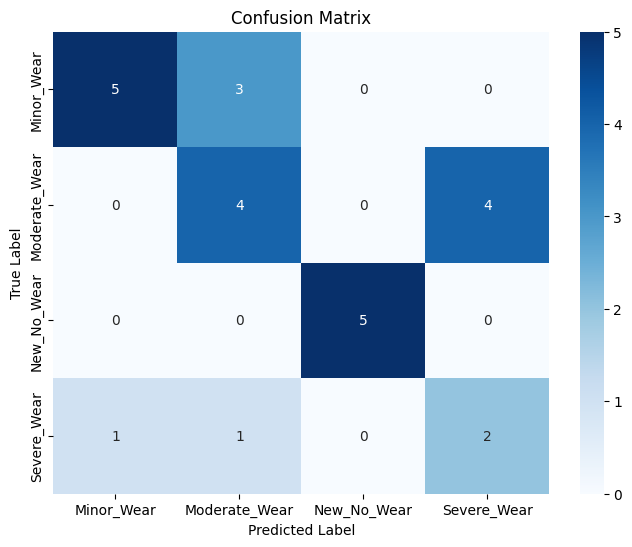


--- ROC Curves ---


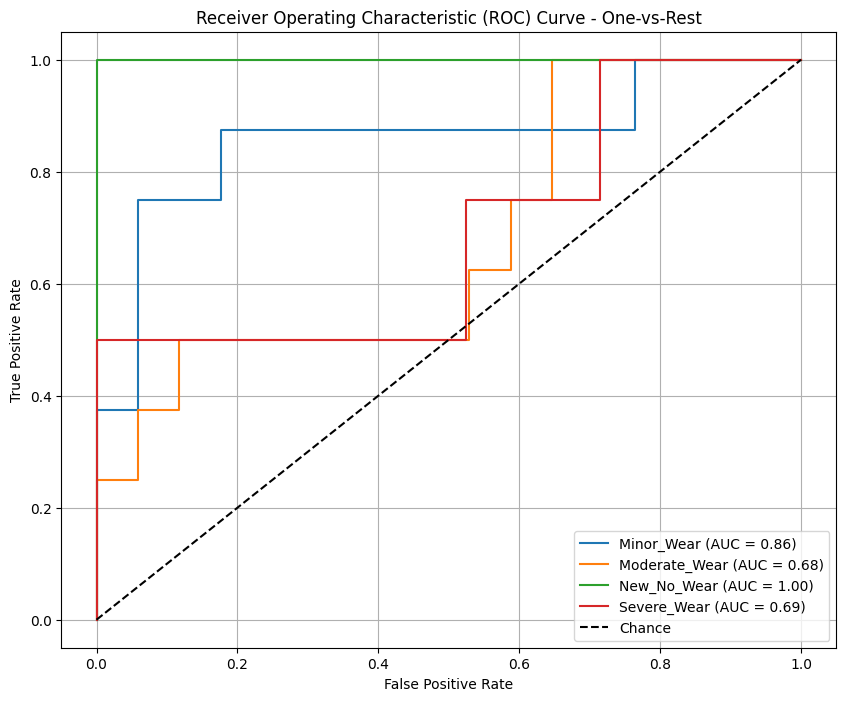


--- Classification Report ---
               precision    recall  f1-score   support

   Minor_Wear       0.83      0.62      0.71         8
Moderate_Wear       0.50      0.50      0.50         8
  New_No_Wear       1.00      1.00      1.00         5
  Severe_Wear       0.33      0.50      0.40         4

     accuracy                           0.64        25
    macro avg       0.67      0.66      0.65        25
 weighted avg       0.68      0.64      0.65        25


--- Model Evaluation Complete ---


In [ ]:
# Import necessary libraries for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure necessary variables are available (assuming they are defined in previous cells)
# X_val, y_val, model, CLASS_LABELS, num_classes

print("--- Starting Model Evaluation ---")

# 1. Make predictions on the validation set
y_pred = model.predict(X_val)

# Convert predictions from probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to class indices
y_true_classes = np.argmax(y_val, axis=1)

print("\n--- Evaluation Metrics ---")
# 2. Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# 3. Compute and display the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4. Calculate and plot the multi-class ROC curves and AUC scores (One-vs-Rest)
print("\n--- ROC Curves ---")
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASS_LABELS[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 5. Generate and print the classification report
print("\n--- Classification Report ---")
report = classification_report(y_true_classes, y_pred_classes, target_names=CLASS_LABELS)
print(report)

print("\n--- Model Evaluation Complete ---")

## Summary:

### Data Analysis Key Findings

*   The model achieved an overall accuracy of 0.6400 on the validation set.
*   The weighted average precision, recall, and F1 score were 0.6800, 0.6400, and 0.6526, respectively.
*   The confusion matrix showed that the model perfectly classified all 5 instances of the 'New\_No\_Wear' class.
*   The ROC AUC analysis revealed that the 'New\_No\_Wear' class had the highest AUC score (1.00), indicating excellent discriminative power for this class against all others. Other classes showed lower AUC scores, suggesting less distinct separation.

### Insights or Next Steps

*   Investigate the classes with lower precision, recall, and AUC scores to understand specific areas of misclassification and potential model improvements.
*   Consider exploring techniques like threshold tuning if optimizing for specific metrics (e.g., recall for a particular class) is crucial for the application.
